In [26]:
# !pip install seaborn 

In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

In [28]:
#Set random seed for reproducibility
np.random.seed(42)

# Simulate user features
n_users = 50000
data = {
    "user_id": np.arange(1, n_users + 1),
    "annual_purchase_value": np.random.uniform(10, 10000, size=n_users),
    "session_activity": np.random.uniform(1, 10, size=n_users),
    "membership_plan": np.random.choice(["monthly", "annual"], size=n_users, p=[0.8, 0.2]),
}

df = pd.DataFrame(data)

# Treatment assignment
logit = -1 + 0.00005 * df['annual_purchase_value'] + 0.05 * (df['session_activity'] / 10) + np.where(df['membership_plan'] == "annual", 0.2, -0.1)
prob = 1 / (1 + np.exp(-logit))
df['avail_free_shipping'] = np.random.binomial(1, p=np.clip(prob, 0, 1))

# Simulate conversion probability
baseline_prob = 0.1 + 0.00002 * df['annual_purchase_value'] + 0.02 * (df['session_activity'] / 10)
df['membership_conversion_prob'] = np.where(
    df['avail_free_shipping'] == 1,
    baseline_prob + 0.05,
    baseline_prob
)
df['membership_conversion'] = np.random.binomial(1, p=np.clip(df['membership_conversion_prob'], 0, 1))

# Clean up
df.drop(columns=['membership_conversion_prob'], inplace=True)

# Convert datatypes
df['user_id'] = df['user_id'].astype(int)
df['annual_purchase_value'] = df['annual_purchase_value'].astype(int)
df['session_activity'] = df['session_activity'].astype(int)
df_encoded = pd.get_dummies(df, columns=['membership_plan'], drop_first=True)
df_encoded['membership_plan_monthly'] = df_encoded['membership_plan_monthly'].astype(int)

In [3]:
# Create panel data
n_weeks = 16  # 8 weeks before and 8 weeks after
weeks = np.arange(-8, 8)

panel_data = pd.DataFrame(np.repeat(df_encoded.values, n_weeks, axis=0), columns=df_encoded.columns)
panel_data['week'] = np.tile(weeks, n_users)

# Simulate revenue over time
panel_data['revenue'] = (
    panel_data['annual_purchase_value'] * 0.001 +
    panel_data['session_activity'] * 0.5 +
    np.random.normal(0, 5, size=panel_data.shape[0])
)

# Apply treatment effect to revenue post-treatment
panel_data['treatment'] = (
    (panel_data['avail_free_shipping'] == 1) & (panel_data['week'] >= 0)
).astype(int)
panel_data['revenue'] += panel_data['treatment'] * 5  # Simulate uplift for treated users

print(panel_data.head(5))

   user_id  annual_purchase_value  session_activity  avail_free_shipping  \
0        1                   3751                 8                    0   
1        1                   3751                 8                    0   
2        1                   3751                 8                    0   
3        1                   3751                 8                    0   
4        1                   3751                 8                    0   

   membership_conversion  membership_plan_monthly  week    revenue  treatment  
0                      0                        1    -8  10.347003          0  
1                      0                        1    -7   2.304081          0  
2                      0                        1    -6   9.586132          0  
3                      0                        1    -5  -6.368954          0  
4                      0                        1    -4  10.561202          0  


In [4]:
# Use only the original encoded data
df_psm = df_encoded.copy()

# Define treatment and covariates
treatment_col = 'avail_free_shipping'
covariates = ['annual_purchase_value', 'session_activity', 'membership_plan_monthly']

# Step 1: Estimate Propensity Scores
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(df_psm[covariates], df_psm[treatment_col])
df_psm['propensity_score'] = log_reg.predict_proba(df_psm[covariates])[:, 1]

# Step 2: Nearest Neighbor Matching (1:1)
treated = df_psm[df_psm[treatment_col] == 1]
control = df_psm[df_psm[treatment_col] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control units
matched_control_indices = control.iloc[indices.flatten()].index
matched_df = pd.concat([treated, control.loc[matched_control_indices]])

print(matched_df.head())

   user_id  annual_purchase_value  session_activity  avail_free_shipping  \
2        3                   7322                 2                    1   
3        4                   5990                 7                    1   
4        5                   1568                 4                    1   
5        6                   1568                 6                    1   
6        7                    590                 1                    1   

   membership_conversion  membership_plan_monthly  propensity_score  
2                      0                        1          0.336104  
3                      0                        1          0.317926  
4                      0                        1          0.271827  
5                      0                        1          0.270773  
6                      0                        0          0.322057  


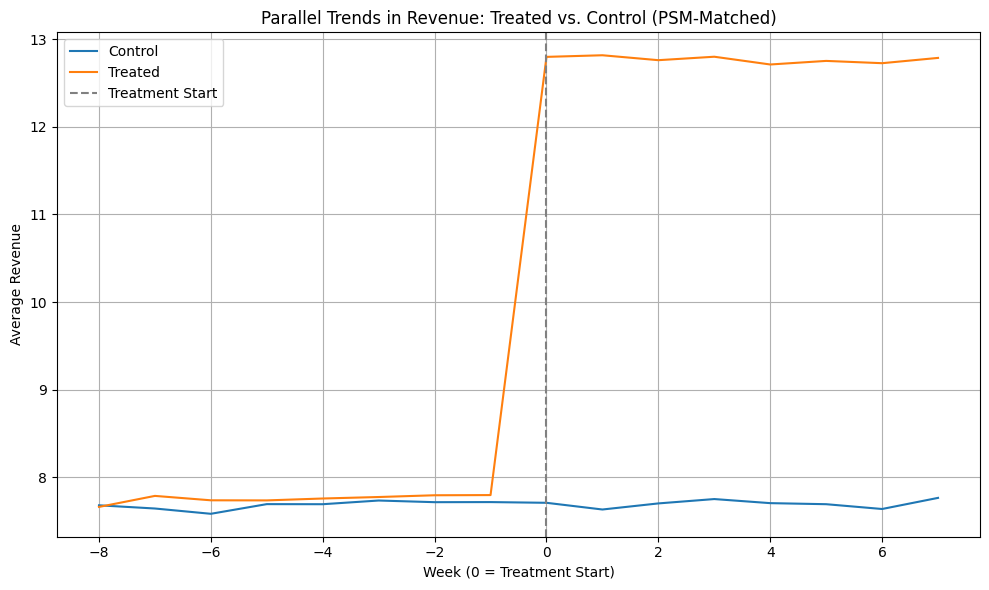

In [5]:
# Filter for matched user_ids
matched_user_ids = matched_df['user_id'].unique()
matched_panel_data = panel_data[panel_data['user_id'].isin(matched_user_ids)]

# Average revenue over weeks by group
avg_revenue = (
    matched_panel_data
    .groupby(['week', 'avail_free_shipping'])['revenue']
    .mean()
    .reset_index()
    .rename(columns={'avail_free_shipping': 'group', 'revenue': 'avg_revenue'})
)
avg_revenue['group'] = avg_revenue['group'].map({1: 'Treated', 0: 'Control'})

# Plot
plt.figure(figsize=(10, 6))
for label, df_group in avg_revenue.groupby('group'):
    plt.plot(df_group['week'], df_group['avg_revenue'], label=label)
plt.axvline(x=0, color='gray', linestyle='--', label='Treatment Start')
plt.title('Parallel Trends in Revenue: Treated vs. Control (PSM-Matched)')
plt.xlabel('Week (0 = Treatment Start)')
plt.ylabel('Average Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

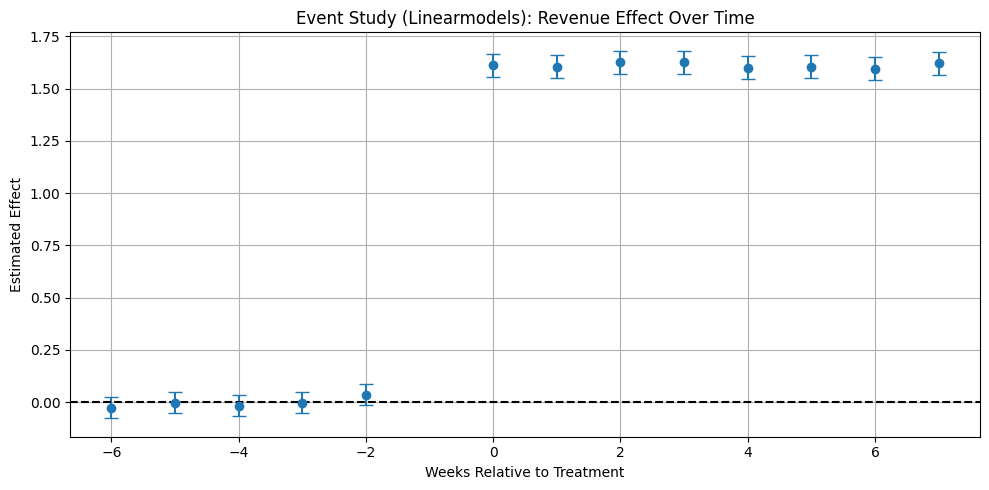

In [6]:
#Event study with lead/lag fixed effects regression

# Step 1: Work on a copy with multi-index
panel_df = panel_data.copy()
panel_df = panel_df.set_index(['user_id', 'week'])

# Step 2: Create lead/lag dummies (skip -1 as baseline)
for k in range(-6, 8):
    if k == -1 or k not in panel_df.index.get_level_values('week'):
        continue
    panel_df[f'd_{k}'] = (panel_df.index.get_level_values('week') == k).astype(int)

# Step 3: Rename safely
for k in range(-6, 8):
    if k == -1 or f'd_{k}' not in panel_df.columns:
        continue
    panel_df[f'd_m{abs(k)}' if k < 0 else f'd_p{k}'] = panel_df[f'd_{k}']

# Step 4: Prepare model inputs
event_dummies = [col for col in panel_df.columns if col.startswith('d_m') or col.startswith('d_p')]
X = panel_df[event_dummies]
y = panel_df['revenue']

# Step 5: Fit model with entity (user) and time (week) fixed effects
model = PanelOLS(y.loc[X.index], X, entity_effects=True)  # <- no time_effects
result = model.fit(cov_type='clustered', cluster_entity=True)

# Step 6: Plot results
coefs = result.params
stderr = result.std_errors
x_vals = [int(name.replace("d_m", "-").replace("d_p", "")) for name in coefs.index]

#Multi collinearity check
np.linalg.matrix_rank(X.values) < X.shape[1]

plt.figure(figsize=(10, 5))
plt.errorbar(
    x_vals,
    coefs.values,
    yerr=1.96 * stderr.values,
    fmt='o',
    capsize=5
)
plt.axhline(0, linestyle='--', color='black')
plt.title("Event Study (Linearmodels): Revenue Effect Over Time")
plt.xlabel("Weeks Relative to Treatment")
plt.ylabel("Estimated Effect")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
#DID regression
# Clean and prepare data
panel_df = panel_data.copy()
panel_df = panel_df.set_index(['user_id', 'week'])

# Drop negative revenue and log-transform
panel_df['revenue'] = panel_df['revenue'].clip(lower=0)
panel_df['log_revenue'] = np.log1p(panel_df['revenue'])

# Define post-treatment and interaction term
panel_df['post'] = (panel_df.index.get_level_values('week') >= 0).astype(int)
panel_df['did'] = panel_df['treatment'] * panel_df['post']

# Use only interaction term to avoid multicollinearity
X = panel_df[['did']]
y = panel_df['log_revenue']

# Fit model with user and week fixed effects
model = PanelOLS(y, X, entity_effects=True, time_effects=True)
result = model.fit(cov_type='clustered', cluster_entity=True)

# View result
print(result.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            log_revenue   R-squared:                        0.0352
Estimator:                   PanelOLS   R-squared (Between):              0.0921
No. Observations:              800000   R-squared (Within):               0.0509
Date:                Fri, Jul 11 2025   R-squared (Overall):              0.0875
Time:                        22:44:26   Log-likelihood                -8.528e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.734e+04
Entities:                       50000   P-value                           0.0000
Avg Obs:                       16.000   Distribution:                F(1,749984)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):          2.591e+04
                            

In [8]:
#Robustness Checks - 1

# Remove users with top 1% revenue to reduce influence of extreme cases
panel_df_wo = panel_df[panel_df['log_revenue'] < panel_df['log_revenue'].quantile(0.99)]

model = PanelOLS.from_formula(
    'log_revenue ~ 1 + did + EntityEffects + TimeEffects',
    data=panel_df_wo  # ← use filtered data
)
result = model.fit(cov_type='clustered', cluster_entity=True)
print(result.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            log_revenue   R-squared:                        0.0331
Estimator:                   PanelOLS   R-squared (Between):              0.0944
No. Observations:              792000   R-squared (Within):               0.0476
Date:                Fri, Jul 11 2025   R-squared (Overall):              0.0611
Time:                        22:44:33   Log-likelihood                 -8.45e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.538e+04
Entities:                       50000   P-value                           0.0000
Avg Obs:                       15.840   Distribution:                F(1,741984)
Min Obs:                      10.0000                                           
Max Obs:                       16.000   F-statistic (robust):          2.375e+04
                            

In [9]:
#Robustness Checks - 2 - Placebo effect

# Copy original panel_df (multi-indexed on user_id and week)
placebo_df = panel_df.copy()

# Define a placebo treatment time (earlier than actual)
placebo_week = 4  # assuming real treatment happens at week 6

# Create placebo post-period dummy
placebo_df['placebo_post'] = (placebo_df.index.get_level_values('week') >= placebo_week).astype(int)

# Create placebo interaction term
placebo_df['placebo_did'] = placebo_df['treatment'] * placebo_df['placebo_post']

# Run DiD regression using placebo interaction term
model_placebo = PanelOLS.from_formula(
    'log_revenue ~ 1 + placebo_did + EntityEffects + TimeEffects',
    data=placebo_df
)

result_placebo = model_placebo.fit(cov_type='clustered', cluster_entity=True)

# Print summary of placebo test
print(result_placebo.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            log_revenue   R-squared:                        0.0115
Estimator:                   PanelOLS   R-squared (Between):              0.0515
No. Observations:              800000   R-squared (Within):               0.0167
Date:                Fri, Jul 11 2025   R-squared (Overall):              0.0276
Time:                        22:44:38   Log-likelihood                -8.625e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8702.3
Entities:                       50000   P-value                           0.0000
Avg Obs:                       16.000   Distribution:                F(1,749984)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):          1.059e+04
                            

In [10]:
#Robustness Checks - 3 - Alternative Control Groups

# Make a fresh copy
panel_df_copy = panel_df.copy()

# Reset index safely: remove 'user_id' and 'week' from columns if already present
panel_df_copy = panel_df_copy.reset_index()
panel_df_copy = panel_df_copy.loc[:, ~panel_df_copy.columns.duplicated()]

# Simulate alt control group (example logic)
panel_df_copy['alt_control_group'] = ((panel_df_copy['treatment'] == 0) & (panel_df_copy['user_id'] % 2 == 0)).astype(int)

# Subset to treated + alt control
panel_df_alt = panel_df_copy[(panel_df_copy['treatment'] == 1) | (panel_df_copy['alt_control_group'] == 1)].copy()

# Re-index
panel_df_alt = panel_df_alt.set_index(['user_id', 'week'])

# Recreate DiD interaction term
panel_df_alt['did'] = panel_df_alt['treatment'] * panel_df_alt['post']

result_alt = PanelOLS.from_formula(
    'log_revenue ~ 1 + did + EntityEffects + TimeEffects',
    data=panel_df_alt
).fit(cov_type='clustered', cluster_entity=True)

# Print results
print(result_alt.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            log_revenue   R-squared:                        0.0328
Estimator:                   PanelOLS   R-squared (Between):              0.2653
No. Observations:              464712   R-squared (Within):               0.0471
Date:                Fri, Jul 11 2025   R-squared (Overall):              0.1043
Time:                        22:44:55   Log-likelihood                -4.782e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.464e+04
Entities:                       33089   P-value                           0.0000
Avg Obs:                       14.044   Distribution:                F(1,431607)
Min Obs:                       8.0000                                           
Max Obs:                       16.000   F-statistic (robust):          1.292e+04
                            

In [13]:
#Robustness Checks - 4 - Varying the Pre/Post Time Window

# Step 1: Copy the panel data
panel_time_check = panel_df.copy().reset_index()

# Step 2: Define the actual treatment start week
treatment_start_week = 6

# Step 3: Create relative week variable
panel_time_check['treated_week'] = panel_time_check['week'] - treatment_start_week

# Step 4: Helper function to subset based on window
def subset_time_window(df, weeks_before=2, weeks_after=2):
    valid_weeks = list(range(-weeks_before, weeks_after + 1))
    return df[df['treated_week'].isin(valid_weeks)].copy()

# Step 5: Create 2-week and 4-week window subsets
panel_df_2wk = subset_time_window(panel_time_check, 2, 2)
panel_df_4wk = subset_time_window(panel_time_check, 4, 4)

# Step 6: Set index for PanelOLS
panel_df_2wk = panel_df_2wk.set_index(['user_id', 'week'])
panel_df_4wk = panel_df_4wk.set_index(['user_id', 'week'])

# Step 7: Run fixed effects DiD regression on 2-week window
model_2wk = PanelOLS.from_formula(
    'log_revenue ~ 1 + did + EntityEffects + TimeEffects',
    data=panel_df_2wk,
    drop_absorbed=True
).fit(cov_type='clustered', cluster_entity=True)

# Step 8: Run fixed effects DiD regression on 4-week window
model_4wk = PanelOLS.from_formula(
    'log_revenue ~ 1 + did + EntityEffects + TimeEffects',
    data=panel_df_4wk,
    drop_absorbed=True
).fit(cov_type='clustered', cluster_entity=True)

# Step 9: Print summaries
print("=== 2-Week Pre/Post Window ===")
print(model_2wk.summary)

print("\n=== 4-Week Pre/Post Window ===")
print(model_4wk.summary)

=== 2-Week Pre/Post Window ===
                          PanelOLS Estimation Summary                           
Dep. Variable:            log_revenue   R-squared:                        0.0000
Estimator:                   PanelOLS   R-squared (Between):              0.2333
No. Observations:              200000   R-squared (Within):               0.0000
Date:                Fri, Jul 11 2025   R-squared (Overall):              0.1179
Time:                        22:52:41   Log-likelihood                -1.813e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0000
Entities:                       50000   P-value                           1.0000
Avg Obs:                       4.0000   Distribution:                F(1,149996)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):          2.041e+

In [20]:
#Robustness Checks - 5 - Varying the Pre/Post Time Window

# Step 1: Copy and re-index panel data
panel_df_cov = panel_df.copy().reset_index().set_index(['user_id', 'week'])

# Create a user-level clustering column (must be Series)
panel_df_cov['cluster_id'] = panel_df_cov.index.get_level_values('user_id')

# Step 2: Baseline DiD Model (No Covariates)
model1 = PanelOLS.from_formula(
    'log_revenue ~ 1 + did + EntityEffects + TimeEffects',
    data=panel_df_cov,
    drop_absorbed=True
)
result1 = model1.fit(cov_type='clustered', clusters=panel_df_cov['cluster_id'])

# Step 3: Add session_activity
model2 = PanelOLS.from_formula(
    'log_revenue ~ 1 + did + session_activity + EntityEffects + TimeEffects',
    data=panel_df_cov,
    drop_absorbed=True
)
result2 = model2.fit(cov_type='clustered', clusters=panel_df_cov['cluster_id'])

# Step 4: Add both session_activity and annual_purchase_value
model3 = PanelOLS.from_formula(
    'log_revenue ~ 1 + did + session_activity + annual_purchase_value + EntityEffects + TimeEffects',
    data=panel_df_cov,
    drop_absorbed=True
)
result3 = model3.fit(cov_type='clustered', clusters=panel_df_cov['cluster_id'])

# Step 5: Compare Results
summary_df = pd.DataFrame({
    "Model": [
        "Baseline",
        "+ session_activity",
        "+ session_activity + annual_purchase_value"
    ],
    "Treatment Coef.": [
        result1.params['did'],
        result2.params['did'],
        result3.params['did']
    ],
    "P-Value": [
        result1.pvalues['did'],
        result2.pvalues['did'],
        result3.pvalues['did']
    ],
    "Lower CI": [
        result1.conf_int().loc['did'][0],
        result2.conf_int().loc['did'][0],
        result3.conf_int().loc['did'][0]
    ],
    "Upper CI": [
        result1.conf_int().loc['did'][1],
        result2.conf_int().loc['did'][1],
        result3.conf_int().loc['did'][1]
    ]
})
print(summary_df)

/var/folders/rp/ytph6r4j1l1_gx1mb7khmgj00000gp/T/ipykernel_12744/3574213197.py:23: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

session_activity

  result2 = model2.fit(cov_type='clustered', clusters=panel_df_cov['cluster_id'])
/var/folders/rp/ytph6r4j1l1_gx1mb7khmgj00000gp/T/ipykernel_12744/3574213197.py:31: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

session_activity, annual_purchase_value

  result3 = model3.fit(cov_type='clustered', clusters=panel_df_cov['cluster_id'])


                                        Model  Treatment Coef.  P-Value  \
0                                    Baseline         0.574384      0.0   
1                          + session_activity         0.574384      0.0   
2  + session_activity + annual_purchase_value         0.574384      0.0   

   Lower CI  Upper CI  
0   0.56739  0.581378  
1   0.56739  0.581378  
2   0.56739  0.581378  


/var/folders/rp/ytph6r4j1l1_gx1mb7khmgj00000gp/T/ipykernel_12744/3574213197.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result1.conf_int().loc['did'][0],
/var/folders/rp/ytph6r4j1l1_gx1mb7khmgj00000gp/T/ipykernel_12744/3574213197.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result2.conf_int().loc['did'][0],
/var/folders/rp/ytph6r4j1l1_gx1mb7khmgj00000gp/T/ipykernel_12744/3574213197.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

In [21]:
from tabulate import tabulate

# Pretty print with tabulate
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))

╒════════════════════════════════════════════╤═══════════════════╤═══════════╤════════════╤════════════╕
│ Model                                      │   Treatment Coef. │   P-Value │   Lower CI │   Upper CI │
╞════════════════════════════════════════════╪═══════════════════╪═══════════╪════════════╪════════════╡
│ Baseline                                   │          0.574384 │         0 │    0.56739 │   0.581378 │
├────────────────────────────────────────────┼───────────────────┼───────────┼────────────┼────────────┤
│ + session_activity                         │          0.574384 │         0 │    0.56739 │   0.581378 │
├────────────────────────────────────────────┼───────────────────┼───────────┼────────────┼────────────┤
│ + session_activity + annual_purchase_value │          0.574384 │         0 │    0.56739 │   0.581378 │
╘════════════════════════════════════════════╧═══════════════════╧═══════════╧════════════╧════════════╛


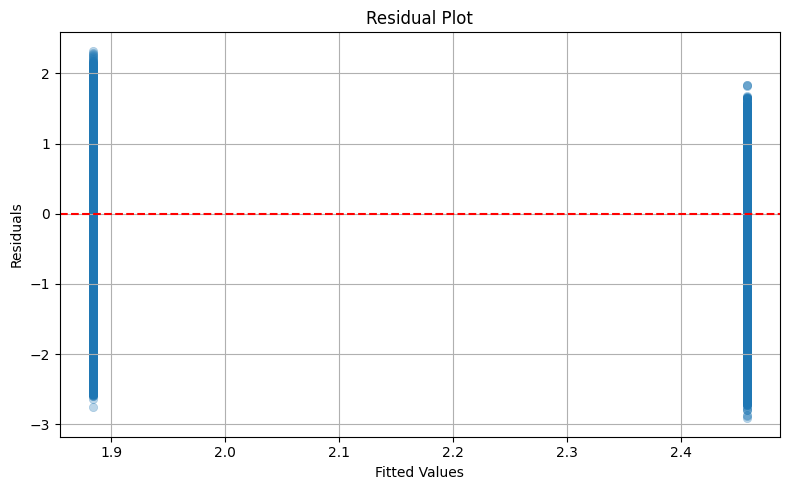


--- Breusch-Pagan Heteroskedasticity Test ---
Lagrange Multiplier Statistic      : 13468.4515
p-value                            : 0.0000
F-value                            : 13699.0490
F p-value                          : 0.0000

--- Durbin-Watson Statistic ---
Durbin-Watson                      : 2.1220


In [35]:
#Step 8 : Diagnostic fit 

# Step 1: Prepare data
panel_df_cov = panel_df.copy().reset_index().set_index(['user_id', 'week'])
panel_df_cov['cluster_id'] = panel_df_cov.index.get_level_values('user_id')

# Step 2: Fit Baseline DiD Model
model1 = PanelOLS.from_formula(
    'log_revenue ~ 1 + did + EntityEffects + TimeEffects',
    data=panel_df_cov,
    drop_absorbed=True
)
result1 = model1.fit(cov_type='clustered', clusters=panel_df_cov['cluster_id'])

# Step 3: Residual Plot
# Extract residuals and fitted values, and flatten to 1D
residuals = result1.resids.values.ravel()
fitted = result1.fitted_values.values.ravel()

# Plot residuals vs fitted values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted, y=residuals, alpha=0.3, edgecolor=None)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Breusch-Pagan Test for Heteroskedasticity
# Use flat residuals and construct X matrix
residuals = result1.resids.values.ravel()
df_bp = panel_df_cov.reset_index()
X = sm.add_constant(df_bp[['did']])

bp_test = het_breuschpagan(residuals, X)
bp_labels = ["Lagrange Multiplier Statistic", "p-value", "F-value", "F p-value"]
bp_results = dict(zip(bp_labels, bp_test))

# Step 5: Durbin-Watson Test for Autocorrelation
dw_stat = durbin_watson(residuals)

# Step 6: Print Results
print("\n--- Breusch-Pagan Heteroskedasticity Test ---")
for k, v in bp_results.items():
    print(f"{k:35s}: {v:.4f}")

print("\n--- Durbin-Watson Statistic ---")
print(f"{'Durbin-Watson':35s}: {dw_stat:.4f}")